## 1) Preprocess all the necessary variables
### 1.1) Build feature, target and initial normalization files

In [6]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
PREFIX = '32_col_lgsc_12m_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 2/4/2019 - This is where this notebook start differing from 001  
1) The new goal is to take into account large-scale forcings in the input file and see if it makes a difference since the CRM knows about them.  
2) If it were the 8-column dataset, I would throw in UBP (the zonal wind) just in case and the Jacobian will be a good way of checking if it makes a difference.  
3) We'll call the new config file 32col_mp_lgsc.  
  
In that file:  
inputs : [QBP, QCBP, QIBP, TBP, UBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Udt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
outputs : [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
  
Error1: There shouldn't be any [1,:] in the preprocess_aqua.py script when calculating the right name based on the dt_adiabatic name.   


In [2]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_lgsc_tbeucler_local.yml \
--aqua_names '*.h1.0000-*-0[1-12]-*' \
--out_pref 32_col_lgsc_12m_train

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 18.47 s
Number of time steps: 1152
Cut time steps: [  95  191  287  383  479  575  671  767  863  959 1055]
Cut time steps: [  95  191  287  383  479  575  671  767  863  959 1055]
Time checkpoint create datasets: 18.72 s
Time checkpoint reshape and rechunk: 27.33 s
Compute means and stds
Saving normalization file: /local/Tom.Beucler/SPCAM_PHYS/32_col_lgsc_12m_train_norm.nc
Time checkpoint normalization arrays: 297.46 s
Time checkpoint rechunk and ds: 298.94 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_lgsc_12m_train_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_lgsc_12m_train_targets.nc
Total time: 401.07 s


### 1.2) Create validation dataset


In [3]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_lgsc_tbeucler_local.yml \
--aqua_names '*.h1.0001-*-0[1-3]-*' \
--out_pref 32_col_lgsc_12m_valid --ext_norm Nope

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 8.10 s
Number of time steps: 432
Cut time steps: [143 287]
Cut time steps: [143 287]
Time checkpoint create datasets: 8.30 s
Time checkpoint reshape and rechunk: 11.52 s
Load external normalization file
Time checkpoint normalization arrays: 11.52 s
Time checkpoint rechunk and ds: 11.86 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_lgsc_12m_valid_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_lgsc_12m_valid_targets.nc
Total time: 73.08 s


### 1.3) Shuffle the training dataset
tgb - 1/16/2019 - Adapted from Stephan's entire worlflow for 32 column run

In [4]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_lgsc_12m_train

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_train_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_train_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_train_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_train_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.31s/it]


In [5]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_lgsc_12m_valid

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_valid_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_valid_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_valid_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_lgsc_12m_valid_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.48s/it]


### 1.4) Change the output's normalization using pressure levels

tgb - 2/6/2019 - See notebook 001 for careful test of each of the steps below

In [7]:
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')  

# Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  
  
dt = 30*60; # timestep
ds.target_conv[:150] = np.multiply(ds.target_conv[:150],np.concatenate((dP,dP,dP,dP,np.divide(dP,dt))))  
  
# Copy old normalization file
path1 = os.path.join(TRAINDIR,PREFIX+'train_norm.nc')
path2 = os.path.join(TRAINDIR,PREFIX+'train_oldnorm.nc')
!cp $path1 $path2  
  
# Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })  
  
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file  
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

## 2) Create data generator and produce data sample


### 2.1) Create data generator from training dataset

In [8]:
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

In [9]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'train_shuffle_features.nc',
    target_fn=PREFIX+'train_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 9338880 samples in 18240 batches
Features have shape 304; targets have shape 158


In [10]:
gen = train_gen_obj.return_generator()
# Produce data sample
x, y = next(gen)
# and check its shape
x.shape, y.shape

((512, 304), (512, 158))

### 2.2) Create data generator from validation dataset and produce sample

In [11]:
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'valid_shuffle_features.nc',
    target_fn=PREFIX+'valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 3514368 samples in 6864 batches
Features have shape 304; targets have shape 158


In [12]:
validgen = valid_gen_obj.return_generator()

xval, yval = next(validgen)

xval.shape, yval.shape

((512, 304), (512, 158))

## 3) Neural network attempts (tgb - started 1/15/2019)

In [13]:
from keras.layers import *
from keras.models import *

### 3.1) Energy conservation strategy (tgb - started 1/18/2019)
#### Step 0: Load all the variables to calculate mass-weighted vertical integrals 

In [14]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (158,)
hyai.shape= (31,)
hybi.shape= (31,)


#### Step 1: Implement mass conservation layer

##### Enforcing mass conservation

Reference for mass and energy conservation:

(Original CAM F90 script, look for "Compute vertical integrals of dry static energy and water" in the script)  
https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/check_energy.F90

(Stephan's energy/mass verification scripts)  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb

##### Mass/Water conservation equation in W/m2

If the network predicts the water vapor tendency, defined as the difference between the moisture before and after physics divided by the timestep dt (normalized in energy units W/m2):
$$\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}$$

The water conservation equation is (normalized in energy units W/m2):
$$\underbrace{\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{v}+\delta q_{l}+\delta q_{i}\right)}_{\mathrm{Difference\ after-before\ physics}}=\underbrace{\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)}_{\mathrm{Cond-Precip\ during\ \Delta t}}
$$

where we have defined:
$$
\widetilde{p}\overset{\mathrm{def}}{=}\frac{p}{p_{\mathrm{norm}}}
$$
$$
\widetilde{t}\overset{\mathrm{def}}{=}\frac{t}{\Delta t}
$$
Note that the precipitation variables here sum up to the water flux from the atmosphere to the surface due to precipitation:
$$
\mathrm{Precipitation\ flux\ atm\rightarrow surf.\ \left[kg.m^{-2}.s^{-1}\right]}=P+10^{-3}\cdot P_{tend}
$$
The idea is to predict all variables but one. The specific humidity at the lowest level of the model (here 30) is likely to be one of the most penalized output variables as it has one of the largest tendencies (in W/m2) in the final cost function. If we predict all other variables and calculate that variable as a residual, it yields:

$$\Delta \widetilde{p}_{30} \delta q_{v}^{30}=\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)-\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{l}+\delta q_{i}\right)-\int_{0}^{\widetilde{p_{30}}}d\widetilde{p}\delta q_{v}
$$

Note that because we are already working with tendencies, the timestep variable dt is not needed in the water conservation layer.




In [157]:
# tgb - 2/5/2019 - Adapated the mass conservation layer to new input format
class MasConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
    
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': list(self.output_dim)}
        base_config = super(MasConsLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=densout]
        # inputs will be [n_sample, 304 = 30*10+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic,
        # Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 124 = 30*4+6-2] with
        # [DELQ\{PHQ AT LOWEST LVL}, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
        CLDVEC = tfm.multiply( dP_TILD, \
                                  tfm.add( densout[:, 29:59], densout[:, 59:89]))
        CLDINT = tfm.reduce_sum( CLDVEC, axis=1)
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
        VAPVEC = tfm.multiply( dP_TILD[:, :29], \
                                  densout[:, :29])
        VAPINT = tfm.reduce_sum( VAPVEC, axis=1)
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( inp[:,303], self.fdiv[303]), self.fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( densout[:, 152], densout[:, 153])
        
        # 5) Infer water vapor tendency at level 30 as a residual
        # Composing tfm.add 3 times because not sure how to use tfm.add_n
        DELQV30 = tfm.divide( \
                             tfm.add( tfm.add( tfm.add (\
                                                        LHF, tfm.negative(PREC)), \
                                              tfm.negative(CLDINT)), \
                                     tfm.negative(VAPINT)), \
                             dP_TILD[:, 29])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
        DELQV30 = tf.expand_dims(DELQV30,1) # Adds dimension=1 to axis=1
        out = tf.concat([densout[:, :29], DELQV30, densout[:, 29:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim) # The output has size 125=30*4+6-1
    # and is ready to be fed to the energy conservation layer
    # before we reach the total number of outputs = 126

#### Step 2: Implement energy conservation layer
##### Energy conservation equation in W/m2

The total energy conservation in CAM is much more delicate than the water mass conservation. One key simplification is that the net advection of moist static energy in the CRM (within a grid-box) is zero, so we only need to focus on the thermodynamics. 
  
  The two reference scripts of SPCAM are:  
1)https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/check_energy.F90 (look for te_tdn)  
2)https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/tphysbc_internallythreaded.F90 (look for wtricesink and icesink)  
  
  Another very useful script is Stephan's attempt at conserving energy/making sense of the variables:  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb  
which is extremely helpful since some NETCDF flags are misleading/have the wrong attributes.  

Following these files, we define the total energy, where the enthalpy component uses the ice as the reference phase of energy 0 (therefore, each gram of water in the forms of liquid or vapor add to the total energy of the system):
$$
e\ \left[\mathrm{J\ kg^{-1}}\right]\overset{\mathrm{def}}{=}\frac{\overrightarrow{u}\cdot\overrightarrow{u}}{2}+c_{p}T+L_{s}q_{v}+L_{f}q_{l}
$$
We then isolate the column tendency of each variable that is due to precipitation or phase change between ice and liquid within the column.
$$
\delta QV_{SP}\ \left[\mathrm{kg\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{v}}{dt}\right)-\frac{\mathrm{LHF}}{L_{v}}
$$
$$
\delta QL_{SP}\ \left[\mathrm{kg\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{l}}{dt}\right)
$$
$$
\delta T_{SP}\ \left[\mathrm{W\ m^{-2}\ K^{-1}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dT}{dt}\right)-\frac{\mathrm{RAD}}{c_{p}}-\frac{\mathrm{SHF}}{c_{p}}-\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dT_{KE}}{dt}\right)
$$
where we have introduced the net radiative heating of the column:
$$
\mathrm{RAD}\overset{\mathrm{def}}{=}\mathrm{SW}_{t}-\mathrm{SW}_{s}+\mathrm{LW}_{s}-\mathrm{LW}_{t}
$$
Physically, we have removed the following energetic contributions:
- The net evaporation due to the latent heat flux from the column water vapor tendency,
- The net radiative flux, the sensible heat flux and the column turbulent dissipation of kinetic energy from the column temperature tendency,
- Nothing from the column liquid water tendency, since it is all due to conversion to vapor or ice.  
  
The next step is to calculate the total energy tendency due to precipitation/phase change by summing all of the components we have calculated before:
$$
\delta E_{\mathrm{SP}}\ \left[\mathrm{W\ m^{-2}}\right]=c_{p}\delta T_{SP}+L_{s}\delta QV_{SP}+L_{f}\delta QL_{SP}
$$
Note that:
- Because the current setup of SPCAM does not resolve momentum transfer, we have left the change in kinetic energy out.
- Because the reference state is ice (and not liquid as is often seen for the frozen moist static energy), the latent heat flux is multiplied by the ratio L_s/L_v>1 of the latent heat of sublimation to the latent heat of vaporization.  
  
The change from phase change/precipitation is a sum of two terms:
  - An energy source from the net change from (liquid) to (ice) within the column "SNOW".
  - An energy sink from the precipitation flux from the (atmopshere) to the (surface) "P".
$$
\delta E_{\mathrm{SP}}\ \left[\mathrm{W\ m^{-2}}\right]=L_{f}\left(SNOW+10^{-3}SNOW_{tend}-P-10^{-3}P_{tend}\ \left[\mathrm{All\ in\ kg\ m^{-2}\ s^{-1}}\right]\right)
$$  
We work with the same non-dimensional variable as before, since all variables have been normalized in the output vector to have units W/m2. Additionally to:
$$
\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}
$$
we now also introduce the level-by-level temperature tendency in units W/m2:
$$
\delta T\left(p\right)\overset{\mathrm{def}}{=}\frac{c_{p}\Delta p_{\mathrm{norm}}}{g}\left(\frac{dT}{dt}\right)\left(p\right)
$$
  
  The equations become:
$$
L_{v}\cdot\delta QV_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{v}-\mathrm{LHF}
$$
$$
L_{v}\cdot\delta QL_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{l}
$$
$$
c_{p}\cdot\delta T_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T-\mathrm{RAD}-\mathrm{SHF}-\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T_{TKE}
$$  
  
  We now isolate the temperature tendency at level 30 and write it as a residual of the energy budget using all the variables normalized to units W/m2:
$$
\begin{aligned}\Delta\widetilde{p}_{30}\cdot\delta T_{30} & =\frac{L_{f}}{L_{v}}\left(L_{v}SNOW+10^{-3}L_{v}SNOW_{tend}-L_{v}P-10^{-3}L_{v}P_{tend}\right)\\
 & +\mathrm{RAD}+\mathrm{SHF}+\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T_{TKE}\\
 & -\frac{L_{s}}{L_{v}}\left(\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{v}-\mathrm{LHF}\right)-\frac{L_{f}}{L_{v}}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{l}\\
 & -\int_{0}^{\widetilde{p_{30}}}d\widetilde{p}\cdot\delta T
\end{aligned}
$$

In [158]:
# tgb - 2/5/2019 - Change to adapt to new input format
class EntConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': list(self.output_dim)}
        base_config = super(MasConsLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=massout]
        # inputs will be [n_sample, 304 = 30*10+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic,
        # Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 157 = 30*5+8-1] with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, DTVKE,
        # FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, massout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                                      tfm.add( massout[:,155], massout[:,156]),\
                                                      tfm.add( massout[:,153], massout[:,154])),\
                                        L_F),\
                          L_V)
        
        # 3) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 3.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( massout[:,149], massout[:,150]),\
                      tfm.subtract( massout[:,152], massout[:,151]))
        # 3.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( inp[:,302], self.fdiv[302]), self.fsub[302])
        # 3.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, massout[:, 119:149])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)
        
        # 4) Calculate tendency of normalized column water vapor due to phase change
        # 4.1) Unnormalize latent heat flux
        LHF = tfm.add( tfm.multiply( inp[:,303], self.fdiv[303]), self.fsub[303])
        # 4.2) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, massout[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 4.3) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                         PHQINT, LHF),\
                                           L_S),\
                             L_V)
        
        # 5) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                            tfm.reduce_sum(\
                                                           tfm.multiply( dP_TILD, massout[:, 30:60]),\
                                                           axis=1),\
                                            L_F),\
                              L_V)
        
        # 6) Same operation for temperature but only integrate from level 1 to level 29
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :29], massout[:, 90:119]), axis=1)

        # 7) Now calculate dT30 as a residual
        dT30 = tfm.divide(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(\
                                                                          PHAS,RAD),\
                                                                  SHF),\
                                                          KEDINT),\
                                                  tfm.negative( SPDQINT)),\
                                          tfm.negative( SPDQCINT)),\
                                  tfm.negative( DTINT)),\
                          dP_TILD[:, 29])
        dT30 = tf.expand_dims(dT30,1)

        out = tf.concat([massout[:, :119], dT30, massout[:, 119:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)
    # and is ready to be used in the cost function

#### Step 3: Implement custom loss function
$$
\mathrm{Loss}\left[\mathrm{W^{2}.m^{-4}}\right]=\alpha\cdot\mathrm{MSE}+\left(1-\alpha\right)\left(\mathrm{Enthalpy\ residual}^{2}+\mathrm{Mass\ residual}^{2}\right)\ \ |\ \ \alpha\in[0,1]
$$
tgb - 2/5/2019- Inspired from 
1) https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred for the custom loss function  
2) https://stackoverflow.com/questions/46464549/keras-custom-loss-function-accessing-current-input-pattern for using the inputs in the custom loss function
Uses the function  massent_check as reference for the square Energy and mass residuals

In [17]:
def customLoss(input_tensor,fsub,fdiv,normq,hyai,hybi,alpha = 0.5):

        # tgb - 2/5/2019 - Loss function written above
    def lossFunction(y_true,y_pred):    
        loss = tfm.multiply(alpha, mse(y_true, y_pred))
        loss += tfm.multiply(tfm.subtract(1.0,alpha), \
                            massent_res(input_tensor,y_pred,fsub,fdiv,normq,hyai,hybi))
        return loss

    # tgb - 2/5/2019 - Mass and enthalpy residual function
    # Adapted from massent_check by converting numpy to tensorflow
    def massent_res(x,y,fsub,fdiv,normq,hyai,hybi):

        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]   

        # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( x[:,300], fdiv[300]), fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, hyai), \
        tfm.multiply( PS[:,None], hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
        tfm.multiply(normq[:30], \
                  G),\
        L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # WATER.1) Calculate water vertical integral from level 1 to level 30
        WATVEC = tfm.multiply( dP_TILD, tfm.add(tfm.add(y[:, :30],\
                                                        y[:, 30:60]),\
                                                y[:, 60:90]))
        WATINT = tfm.reduce_sum( WATVEC, axis=1)

        # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( x[:,303], fdiv[303]), fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( y[:, 154], y[:, 155])

        # WATER.FINAL) Residual = E-P-DWATER/DT
        WATRES = tfm.add(tfm.add(LHF,\
                                 tfm.negative(PREC)),\
                         tfm.negative(WATINT))

        # ENTHALPY.1) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                              tfm.add( y[:,156], y[:,157]),\
                                              tfm.add( y[:,154], y[:,155])),\
                                      L_F),\
                         L_V)

        # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( y[:,150], y[:,151]),\
                      tfm.subtract( y[:,153], y[:,152]))
        # 2.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( x[:,302], fdiv[302]), fsub[302])
        # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, y[:, 120:150])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)

        # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
        # 3.1) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, y[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 3.2) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                     PHQINT, LHF),\
                                        L_S),\
                           L_V)

        # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                      tfm.reduce_sum(\
                                             tfm.multiply( dP_TILD, y[:, 30:60]),\
                                             axis=1),\
                                      L_F),\
                         L_V)

        # ENTHALPY.5) Same operation for temperature tendency
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)

        # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
        ENTRES = tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(SPDQINT,\
                                                                 SPDQCINT),\
                                                         DTINT),\
                                                 tfm.negative(RAD)),\
                                         tfm.negative(SHF)),\
                                 tfm.negative(PHAS)),\
                         tfm.negative(KEDINT))
        # Return sum of water and enthalpy square residuals
        return tfm.add( tfm.square(WATRES), tfm.square(ENTRES))

    return lossFunction

#### Step 4: Formulate mass/energy conserving model, and unconstrained model
We start with inputs [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] of shape 304.  
We then have a few dense layers with size proportional to a power of 2
  
For now, there is no other "physically-constraining" layers than  
the mass+energy conservation layers which take input of shape 156  
  
After mass layer outputs vector of shape 157  
After energy layer outputs final vector of shape 158  
i.e. [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]

In [25]:
# Conservative model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='relu')(inp)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
densout = Dense(156, activation='relu')(densout)    
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
mod_cons_5dens = Model(inputs=inp, outputs=out)

In [26]:
# Same model, unconstrained
inp = Input(shape=(304,))
densout = Dense(512, activation='relu')(inp)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
mod_uncons_5dens = Model(inputs=inp, outputs=out)

In [27]:
# Using a Lagrange multipler in the loss function
# alpha = 0.5 (equal contrib from MSE and residual)
inp05 = Input(shape=(304,))
densout = Dense(512, activation='relu')(inp05)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
mod_lagr05_5dens = Model(inputs=inp05, outputs=out)

In [28]:
# alpha = 0.01 (mostly residual)
inp001 = Input(shape=(304,))
densout = Dense(512, activation='relu')(inp001)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
mod_lagr001_5dens = Model(inputs=inp001, outputs=out)

In [29]:
# alpha = 0.99 (mostly mse)
inp099 = Input(shape=(304,))
densout = Dense(512, activation='relu')(inp099)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
mod_lagr099_5dens = Model(inputs=inp099, outputs=out)

In [136]:
# USING ELU instead of RELU
# Conservative model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='elu')(inp)
for i in range (4):
    densout = Dense(512, activation='elu')(densout)
densout = Dense(156, activation='elu')(densout)    
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
elu_cons_5dens = Model(inputs=inp, outputs=out)

tgb - 2/6/2019 - Added the leaky ReLU using the following issue:  
https://github.com/keras-team/keras/issues/117  

In [140]:
# Using LeakyRELU instead of RELU
# Conservative model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(156, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
lru_cons_5dens = Model(inputs=inp, outputs=out)

tgb - 2/6/2019 - It really looks like LeakyReLU (for now with alpha=0.3) is the best activation function by far to minimize the MSE. So we'll:  
(1) Play with the optimizer using this one.  
(2) Re-write all other networks using LeakyReLU

In [159]:
# Playing with the optmizer
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(156, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
adam_cons_5dens = Model(inputs=inp, outputs=out)
rmsp_cons_5dens = Model(inputs=inp, outputs=out)

tgb - 2/5/2019 - Here, I compile the standard models with .compile(optimizer,loss)  
or the model with custom loss function with .compile(loss=custom_loss_wrapper(input_tensor), optimizer=XX)  
See  https://stackoverflow.com/questions/46464549/keras-custom-loss-function-accessing-current-input-pattern for more information.

In [30]:
mod_lagr05_5dens.compile(loss=customLoss(inp05,fsub,fdiv,normq,hyai,hybi,alpha = 0.5),\
                       optimizer='adadelta')
mod_lagr001_5dens.compile(loss=customLoss(inp001,fsub,fdiv,normq,hyai,hybi,alpha = 0.01),\
                       optimizer='adadelta')
mod_lagr099_5dens.compile(loss=customLoss(inp099,fsub,fdiv,normq,hyai,hybi,alpha = 0.99),\
                       optimizer='adadelta')
mod_uncons_5dens.compile('adadelta','mse')
mod_cons_5dens.compile('adadelta','mse')
#mod_uncons_5dens.compile('adadelta','mse') # careful, apparently compile does NOT reset weights and biases
# See https://stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow

In [160]:
#lru_cons_5dens.compile('adam','mse')
adam_cons_5dens.compile('adam','mse')
rmsp_cons_5dens.compile('rmsprop','mse')

In [31]:
mod_lagr099_5dens.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 304)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               156160    
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_59 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_60 (Dense)             (None, 158)               81054     
Total para

In [32]:
hist_cons_5dens = mod_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hist_uncons_5dens = mod_uncons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hist_lagr001_5dens = mod_lagr001_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hist_lagr05_5dens = mod_lagr05_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hist_lagr099_5dens = mod_lagr099_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 118s 6ms/step - loss: 371.3804 - val_loss: 326.6218
Epoch 2/20
18240/18240 [==============================] - 117s 6ms/step - loss: 349.1694 - val_loss: 323.1239
Epoch 3/20
18240/18240 [==============================] - 118s 6ms/step - loss: 346.4878 - val_loss: 320.4665
Epoch 4/20
18240/18240 [==============================] - 118s 6ms/step - loss: 344.9574 - val_loss: 319.7903
Epoch 5/20
18240/18240 [==============================] - 117s 6ms/step - loss: 343.5766 - val_loss: 319.2748
Epoch 6/20
18240/18240 [==============================] - 117s 6ms/step - loss: 342.9424 - val_loss: 319.5158
Epoch 7/20
18240/18240 [==============================] - 118s 6ms/step - loss: 342.4227 - val_loss: 318.3023
Epoch 8/20
18240/18240 [==============================] - 117s 6ms/step - loss: 341.9585 - val_loss: 316.8653
Epoch 9/20
18240/18240 [==============================] - 118s 6ms/step - loss: 341.5304 - val_loss: 317.0472
Epoch 10/2

18240/18240 [==============================] - 114s 6ms/step - loss: 272.3364 - val_loss: 251.9014
Epoch 16/20
18240/18240 [==============================] - 114s 6ms/step - loss: 271.8901 - val_loss: 251.0177
Epoch 17/20
18240/18240 [==============================] - 114s 6ms/step - loss: 271.3072 - val_loss: 250.3921
Epoch 18/20
18240/18240 [==============================] - 114s 6ms/step - loss: 270.9941 - val_loss: 249.5839
Epoch 19/20
18240/18240 [==============================] - 114s 6ms/step - loss: 268.8478 - val_loss: 245.9416
Epoch 20/20
18240/18240 [==============================] - 114s 6ms/step - loss: 266.0636 - val_loss: 247.5881
Epoch 1/20
18240/18240 [==============================] - 115s 6ms/step - loss: 415.2588 - val_loss: 358.4284
Epoch 2/20
18240/18240 [==============================] - 114s 6ms/step - loss: 387.8688 - val_loss: 355.3531
Epoch 3/20
18240/18240 [==============================] - 114s 6ms/step - loss: 385.0520 - val_loss: 349.8266
Epoch 4/20
18240

In [138]:
helu_cons_5dens = elu_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 121s 7ms/step - loss: 336.0688 - val_loss: 296.3247
Epoch 2/20
18240/18240 [==============================] - 120s 7ms/step - loss: 323.7683 - val_loss: 4825.6380
Epoch 3/20
18240/18240 [==============================] - 120s 7ms/step - loss: 3513402.9420 - val_loss: 249521.3613
Epoch 4/20
18240/18240 [==============================] - 120s 7ms/step - loss: 9099521.8309 - val_loss: 1026.3550
Epoch 5/20
18240/18240 [==============================] - 120s 7ms/step - loss: 4348890.6503 - val_loss: 66898.1627
Epoch 6/20
18240/18240 [==============================] - 120s 7ms/step - loss: 12398213.6755 - val_loss: 776569.5652
Epoch 7/20
18240/18240 [==============================] - 120s 7ms/step - loss: 1885788.1738 - val_loss: 28543841.1049
Epoch 8/20
18240/18240 [==============================] - 120s 7ms/step - loss: 9232902.0532 - val_loss: 453502.1447
Epoch 9/20
18240/18240 [==============================] - 120s 7ms/step - los

In [ ]:
#hlru_cons_5dens = lru_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
#                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hadam_cons_5dens = adam_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hrmsp_cons_5dens = rmsp_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 124s 7ms/step - loss: 143.7763 - val_loss: 123.7583
Epoch 2/20
18240/18240 [==============================] - 122s 7ms/step - loss: 125.2671 - val_loss: 118.8519
Epoch 3/20
18240/18240 [==============================] - 122s 7ms/step - loss: 121.1419 - val_loss: 117.5974
Epoch 4/20
18240/18240 [==============================] - 122s 7ms/step - loss: 122.9960 - val_loss: 117.9073
Epoch 5/20
18240/18240 [==============================] - 122s 7ms/step - loss: 117.7650 - val_loss: 114.3308
Epoch 6/20
18240/18240 [==============================] - 122s 7ms/step - loss: 139.1800 - val_loss: 129.2564
Epoch 7/20
18240/18240 [==============================] - 122s 7ms/step - loss: 135.2529 - val_loss: 114.4186
Epoch 8/20
18240/18240 [==============================] - 122s 7ms/step - loss: 118.4068 - val_loss: 114.1655
Epoch 9/20
 9767/18240 [===============>..............] - ETA: 49s - loss: 113.9331

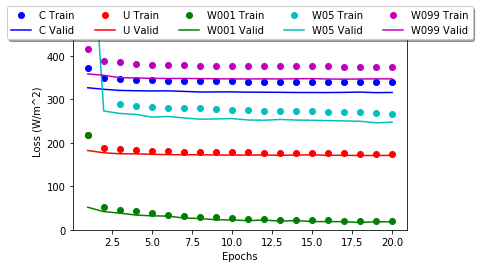

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

for index in range (5):
    if index==0: hdict = hist_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'C';
    elif index==1: hdict = hist_uncons_5dens.history; colo = 'ro'; col = 'r'; lab = 'U';
    elif index==2: hdict = hist_lagr001_5dens.history; colo = 'go'; col = 'g'; lab = 'W001';
    elif index==3: hdict = hist_lagr05_5dens.history; colo = 'co'; col = 'c'; lab = 'W05';
    elif index==4: hdict = hist_lagr099_5dens.history; colo = 'mo'; col = 'm'; lab = 'W099';
        
    
    train_loss_values = hdict['loss']
    valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

#plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (W/m^2)')
plt.ylim((0, 500))
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# for legend at the right place
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True); 
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(); ax = plt.subplot(111)

for index in range (3):
    if index==0: hdict = hist_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'Adadelta';
    elif index==1: hdict = hadam_cons_5dens.history; colo = 'ro'; col = 'r'; lab = 'Adam';
    elif index==2: hdict = hrmsp_cons_5dens.history; colo = 'go'; col = 'g'; lab = 'RmsProp';
        
    
    train_loss_values = hdict['loss']; valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

plt.xlabel('Epochs'); plt.ylabel('Loss (W/m^2)'); plt.ylim((0, 500))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True); plt.show()

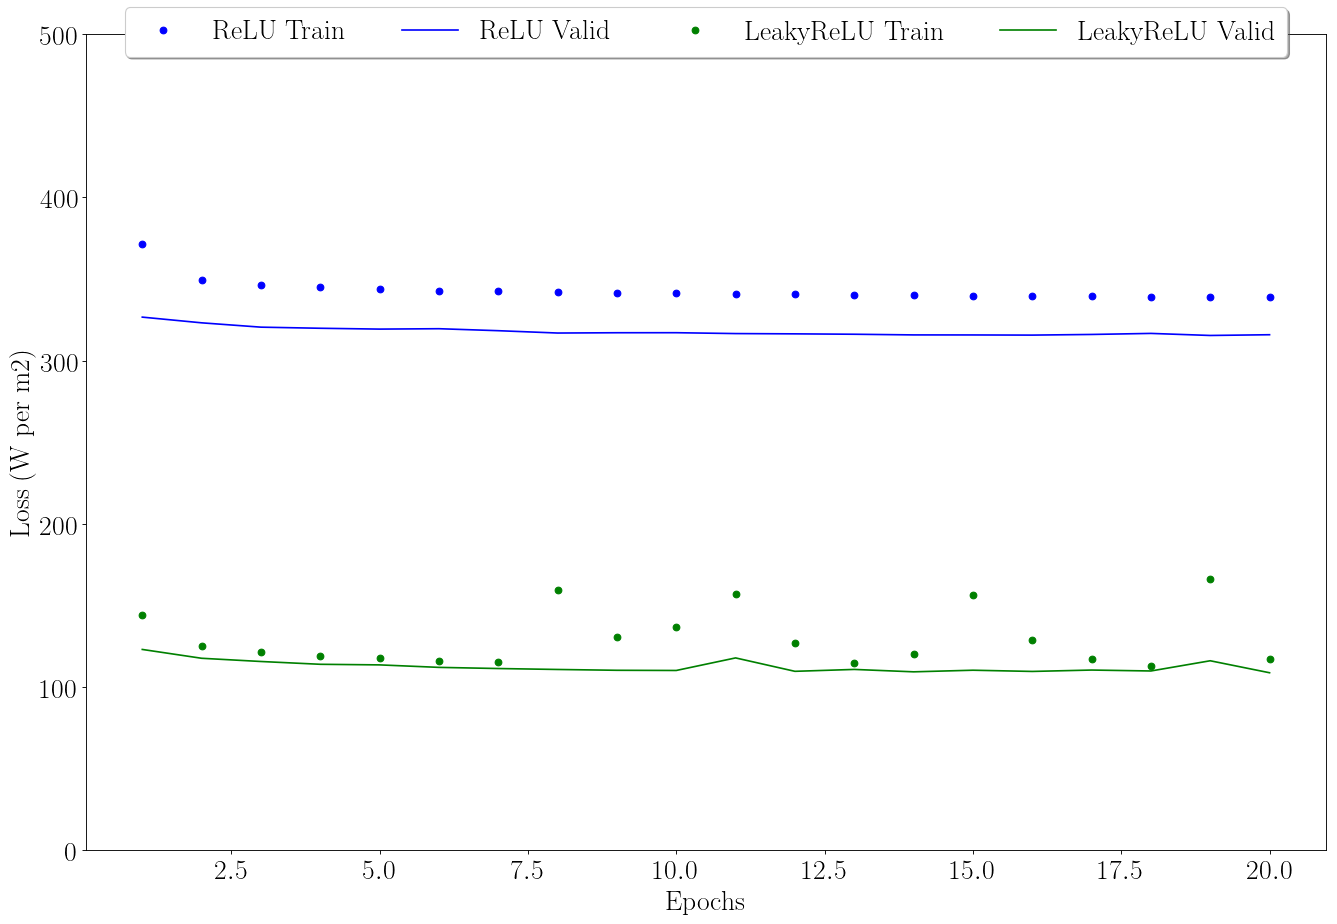

In [156]:
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

for index in range (2):
    if index==0: hdict = hist_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'ReLU';
    elif index==2: hdict = helu_cons_5dens.history; colo = 'ro'; col = 'r'; lab = 'ExpLU';
    elif index==1: hdict = hlru_cons_5dens.history; colo = 'go'; col = 'g'; lab = 'LeakyReLU';
        
    
    train_loss_values = hdict['loss']; valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

plt.xlabel('Epochs', fontsize=25); plt.ylabel('Loss (W per m2)', fontsize=25);
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.ylim((0, 500))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize=25); plt.show()

truth= [ 7.9672202e-05  4.7920624e-04  2.4025740e-02  5.5195879e-02
  1.1413122e-01  9.9763870e-02  2.2796452e-02  8.7691424e-03
  9.2103053e-03  7.1256983e-01  7.7988184e+02  5.6302869e+02
  2.6318073e+02  6.2778019e+01  6.9902046e-03 -7.8684932e-01
  0.0000000e+00 -2.4350360e-01]
unconstrained= [  0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.3625866 788.68677   562.22266
 282.95648    55.21782     5.0673413   0.          0.          0.       ]
conserving= [0.         0.4019227  0.00784189 0.03601322 0.         0.46972626
 0.20347854 0.31218743 0.21515115 0.         0.         0.
 0.         0.         0.15628235 0.2403318  0.10572945 0.        ]


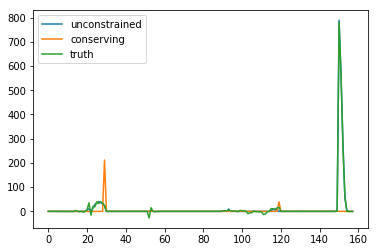

In [34]:
pred_uncons = mod_uncons_5dens.predict_on_batch(x)
pred_cons = mod_cons_5dens.predict_on_batch(x)
ind_test = 150;
plt.plot(pred_uncons[ind_test,:], label='unconstrained')
plt.plot(pred_cons[ind_test,:], label='conserving')
plt.plot(y[ind_test,:], label='truth')
plt.legend();
print('truth=',y[ind_test,140:])
print('unconstrained=',pred_uncons[ind_test,140:])
print('conserving=',pred_cons[ind_test,140:])

#### Step 5: Check energy and mass conservation for the predictions
If we coded the mass/enthalpy conservation layers properly  
pred_cons from the mass/enthalpy-conserving model_cons should conserve mass/energy  
pred_uncons which is a "naive" dense network should not a priori conserve mass/energy  
The function below is directly adapted from the tested mass/enthalpy conservation layers in numpy that have been used to develop the tensorflow layers

In [110]:
def massent_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="graph"):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 154], y[:, 155])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,156], y[:,157]),\
                                          np.add( y[:,154], y[:,155])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,150], y[:,151]),\
            np.subtract( y[:,153], y[:,152]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 120:150])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT
    
    if outtype=="graph":
    
        import matplotlib.pyplot as plt
        from matplotlib import rc
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(121)
        plt.hist(WATRES)
        plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)

        plt.subplot(122)
        plt.hist(ENTRES)
        plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    elif outtype=="list":
    
        return WATRES,ENTRES 

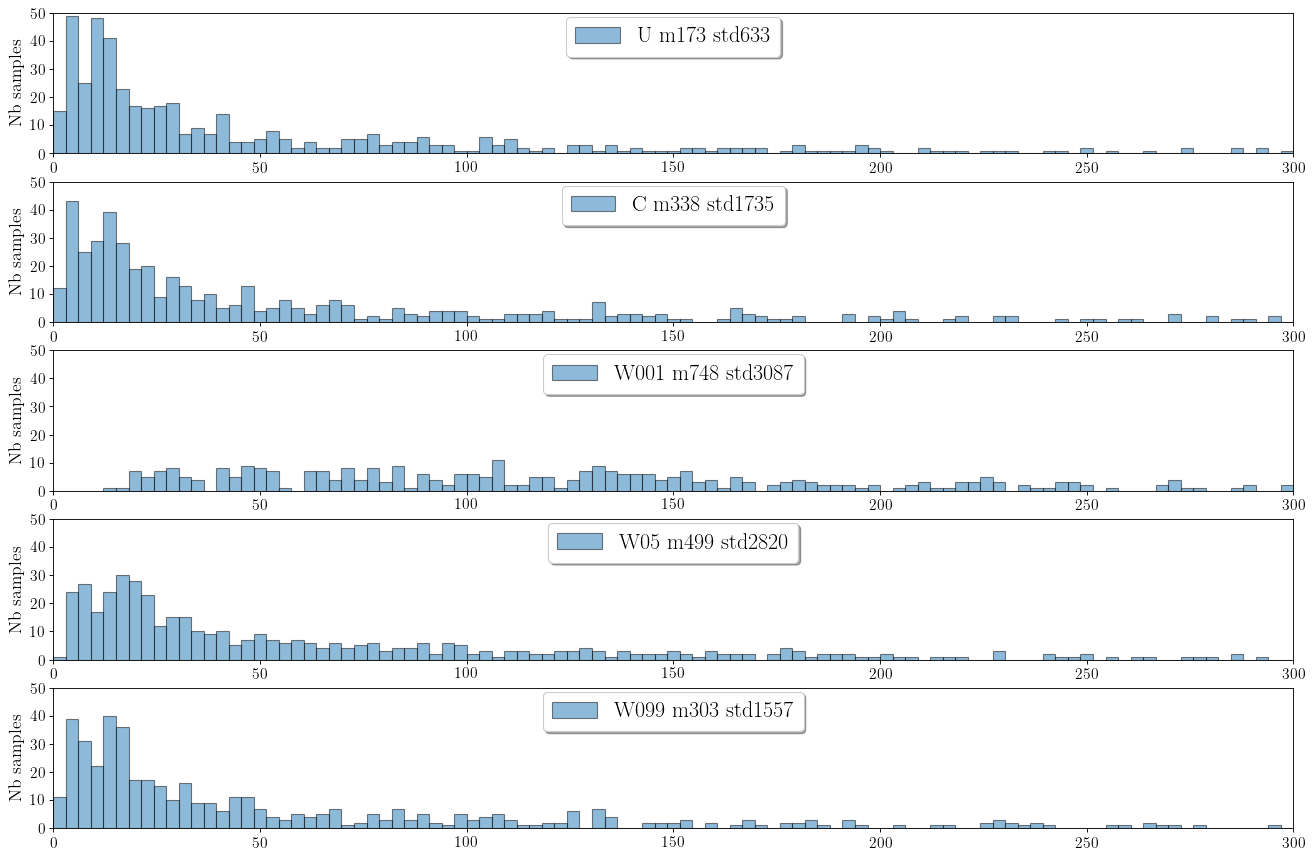

In [108]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 300; bins = np.linspace(0, XMAX, 100)

xval, yval = next(validgen)

for index in range (5):
    if index==0: pred = mod_uncons_5dens.predict_on_batch(xval); lab = 'U';
    elif index==1: pred = mod_cons_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = mod_lagr001_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = mod_lagr05_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = mod_lagr099_5dens.predict_on_batch(xval); lab = 'W099';

    res = np.mean((pred-yval)**2, axis=1);
    
    ax = plt.subplot(5,1,index+1)
    ax.hist(res, bins, alpha=0.5, edgecolor='k', label = lab+' m%i' %np.mean(res)+' std%i' %np.std(res))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((0, XMAX));
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

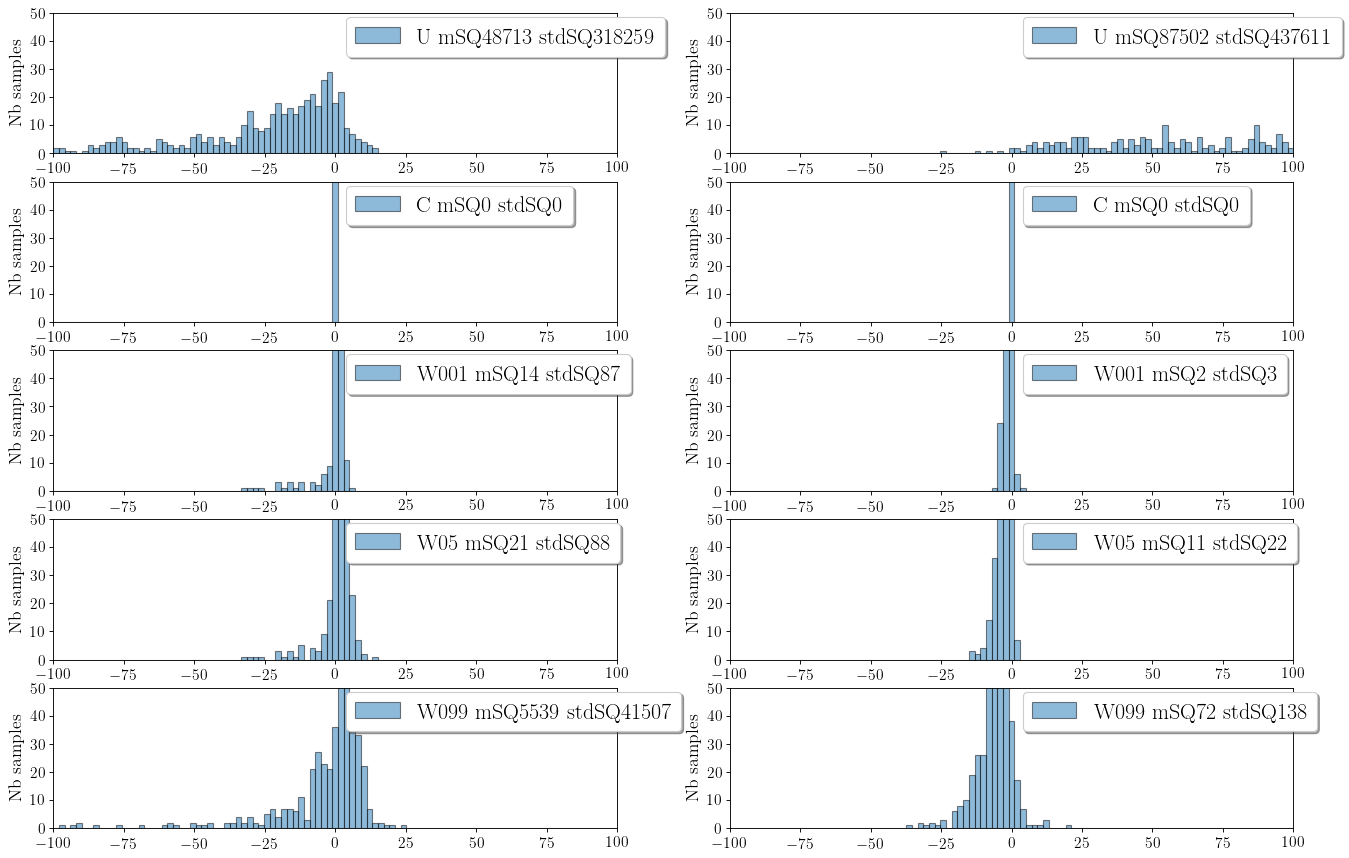

In [122]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(gen)

for index in range (5):
    if index==0: pred = mod_uncons_5dens.predict_on_batch(xval); lab = 'U';
    elif index==1: pred = mod_cons_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = mod_lagr001_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = mod_lagr05_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = mod_lagr099_5dens.predict_on_batch(xval); lab = 'W099';

    watres,entres = massent_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="list");

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(watres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(watres**2)+' stdSQ%i' %np.std(watres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(entres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(entres**2)+' stdSQ%i' %np.std(entres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

#### Step 6: Check positivity of water species
There are two necessary steps:  
1) Load the water species concentrations "before physics" from the input vector and unnormalize them  
2) Invert the output normalization to get the water concentrations "after physics"

$$
\delta q_{v,i,l}\left(p\right)=\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}\ \Rightarrow\ q_{v,i,l}^{a}\left(p\right)=q_{v,i,l}^{b}\left(p\right)+\frac{g\Delta t}{L_{v}\Delta p_{\mathrm{norm}}}\delta q_{v,i,l}\left(p\right)
$$

In [145]:
def watpos_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,dt=30*60):
    
    import numpy as np

    # 1) Extract water species concentrations from inputs
    QVB = np.add( np.multiply( x[:, :30], fdiv[ :30]), fsub[ :30])
    QLB = np.add( np.multiply( x[:, 30:60], fdiv[ 30:60]), fsub[ 30:60])
    QSB = np.add( np.multiply( x[:, 60:90], fdiv[ 60:90]), fsub[ 60:90])

    # 2) Inverse output normalization and get water concentration after physics
    QVA = QVB + np.divide( dt*y[:, :30] , normq[:30])
    QLA = QLB + np.divide( dt*y[:, 30:60] , normq[:30])
    QSA = QSB + np.divide( dt*y[:, 60:90] , normq[:30])

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(231)
    plt.hist(1e3*QVA)
    plt.xlabel(r"$\mathrm{Water\ vapor\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(232)
    plt.hist(1e3*QLA)
    plt.xlabel(r"$\mathrm{Liquid\ water\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(233)
    plt.hist(1e3*QSA)
    plt.xlabel(r"$\mathrm{Ice\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(234)
    plt.hist(1e3*(QVA-QVB))
    plt.xlabel(r"$\mathrm{Water\ vapor\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(235)
    plt.hist(1e3*(QLA-QLB))
    plt.xlabel(r"$\mathrm{Liquid\ water\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(236)
    plt.hist(1e3*(QSA-QSB))
    plt.xlabel(r"$\mathrm{Ice\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

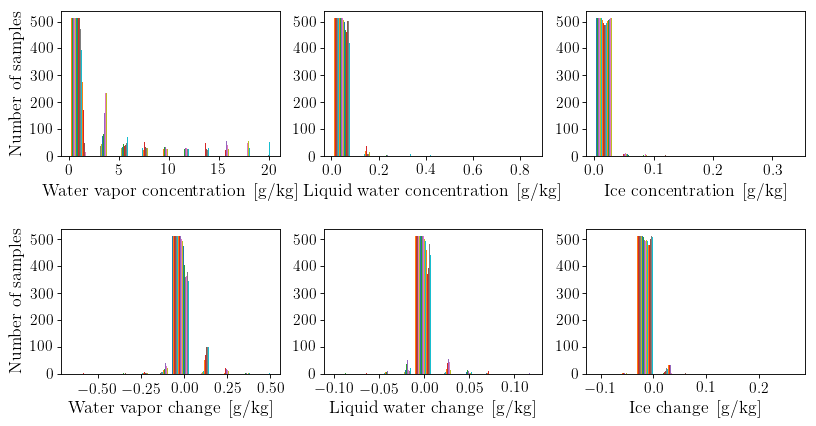

In [146]:
watpos_check(xval,yval,fsub,fdiv,normq,dt)

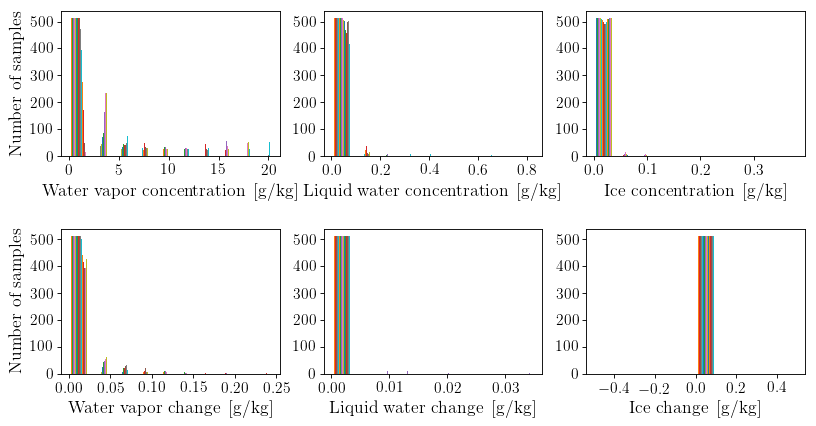

In [154]:
watpos_check(xval,pred6,fsub,fdiv,normq,dt)

#### Last step: Save trained models as h5 files

In [33]:
%cd $TRAINDIR/HDF5_DATA
!pwd
#model1.save('model1.h5')
#model2.save('model2.h5')
#model3.save('model3.h5')
#model4.save('model4.h5')
#model5.save('model5.h5')
#model6.save('model6.h5')
mod_lagr05_5dens.save('mod_lagr05_5dens.h5')
mod_lagr001_5dens.save('mod_lagr001_5dens.h5')
mod_lagr099_5dens.save('mod_lagr099_5dens.h5')
mod_uncons_5dens.save('mod_uncons_5dens.h5')
mod_cons_5dens.save('mod_cons_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
